In [2]:
import h5py
import numpy as np
import requests
import getpass
import socket
import json
import zipfile
import io
import math
from glob import glob
import os
import shutil
import pprint
import time
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import re
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# To read KML files with geopandas, we will need to enable KML support in fiona (disabled by default)
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
from shapely.geometry import Polygon, mapping
from shapely.geometry.polygon import orient
from statistics import mean
from requests.auth import HTTPBasicAuth
from readers.read_HDF5_ATL03 import read_HDF5_ATL03
from readers.get_ATL03_x_atc import get_ATL03_x_atc


In [13]:
# Creating a token

# Earthdata Login credentials

# Enter your Earthdata Login user name
uid = 'zhfair'
# Enter your email address associated with your Earthdata Login account
email = 'zhfair@umich.edu'
pswd = getpass.getpass('Earthdata Login password: ')

Earthdata Login password:  ·················


In [14]:
# Request token from Common Metadata Repository using Earthdata credentials
token_api_url = 'https://cmr.earthdata.nasa.gov/legacy-services/rest/tokens'
hostname = socket.gethostname()
ip = socket.gethostbyname(hostname)

data = {
    'token': {
        'username': uid,
        'password': pswd,
        'client_id': 'NSIDC_client_id',
        'user_ip_address': ip
    }
}
headers={'Accept': 'application/json'}
response = requests.post(token_api_url, json=data, headers=headers)
token = json.loads(response.content)['token']['id']
print(token)

63857721-5E32-7F6D-B1EE-4942B57CAE40


In [15]:
# Data set ID
short_name = 'ATL06'

In [16]:
# Get json response from CMR collection metadata and print results. This provides high-level metadata on a data set or "collection", provide in json format.

params = {
    'short_name': short_name
}

cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
response = requests.get(cmr_collections_url, params=params)
results = json.loads(response.content)
pprint.pprint(results)

{'feed': {'entry': [{'archive_center': 'NASA NSIDC DAAC',
                     'associations': {'services': ['S1568899363-NSIDC_ECS',
                                                   'S1613689509-NSIDC_ECS',
                                                   'S1613669681-NSIDC_ECS']},
                     'boxes': ['-90 -180 90 180'],
                     'browse_flag': False,
                     'coordinate_system': 'CARTESIAN',
                     'data_center': 'NSIDC_ECS',
                     'dataset_id': 'ATLAS/ICESat-2 L3A Land Ice Height V001',
                     'has_formats': True,
                     'has_spatial_subsetting': True,
                     'has_temporal_subsetting': True,
                     'has_transforms': False,
                     'has_variables': True,
                     'id': 'C1511847675-NSIDC_ECS',
                     'links': [{'href': 'https://n5eil01u.ecs.nsidc.org/ATLAS/ATL06.001/',
                                'hreflang': 'en-US',
 

In [17]:
# Find all instances of 'version_id' in metadata and print most recent version number

versions = [i['version_id'] for i in results['feed']['entry']]
latest_version = max(versions)
print(latest_version)

001


In [18]:
# Input temporal range 

# Input start date in yyyy-MM-dd format
start_date = '2019-01-02'
# Input start time in HH:mm:ss format
start_time = '00:00:00'
# Input end date in yyyy-MM-dd format
end_date = '2019-01-02'
# Input end time in HH:mm:ss format
end_time = '23:59:59'

temporal = start_date + 'T' + start_time + 'Z' + ',' + end_date + 'T' + end_time + 'Z'
print(temporal)

2019-01-02T00:00:00Z,2019-01-02T23:59:59Z


In [19]:
# # Commenting for tutorial since we will be walking through option 3 (spatial file input) together
# # Bounding Box spatial parameter in 'W,S,E,N' format

# # Input bounding box
# # Input lower left longitude in decimal degrees
LL_lon = '-64'
# # Input lower left latitude in decimal degrees
# LL_lat = '66'
# # Input upper right longitude in decimal degrees
# UR_lon = '-55'
# # Input upper right latitude in decimal degrees
# UR_lat = '72'

# bounding_box = LL_lon + ',' + LL_lat + ',' + UR_lon + ',' + UR_lat
# # aoi value used for CMR params below
# aoi = '1'
# print(bounding_box)

In [8]:
# Identify directory and primary groups within ATL06
dir = '/home/jovyan/ATL06/'
file = ''

!h5ls '/home/jovyan/ATL06/ATL06_20190102184312_00810210_001_01.h5'

METADATA                 Group
ancillary_data           Group
gt1l                     Group
gt1r                     Group
gt2l                     Group
gt2r                     Group
gt3l                     Group
gt3r                     Group
orbit_info               Group
quality_assessment       Group


In [11]:
# Grabbing the data, sticking to the center strong laser
with h5py.File('/home/jovyan/ATL06/ATL06_20190102184312_00810210_001_01.h5') as f:
    elev_land_ice = f['/gt2l/land_ice_segments/h_li'][:]
    xatc_land_ice = f['/gt2l/land_ice_segments/ground_track/x_atc'][:]
    
print(len(elev_land_ice))
print(len(xatc_land_ice))

elev_land_ice[elev_land_ice > 10000] = np.nan

65123
65123


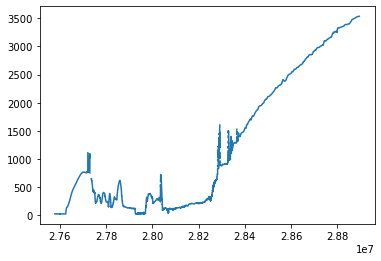

In [12]:
# Plotting the basic ATL06 data, to know what we are looking at
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(xatc_land_ice,elev_land_ice)
plt.show()